In [1]:
# importing necessary libraries
import pandas as pd
import numpy as np
import copy
import random

# -------------------- PARAMETERS --------------------

In [2]:
# name of a csv data file 
filename = 'income'

In [3]:
df = pd.read_csv('datasets\\' + filename + '.csv', sep=';')
df_original = df.copy(deep=True)

In [4]:
# if class is provided with the data
provided_class = True

In [5]:
# determining the number of clusters (k) into which we divide the set
k = 3

In [6]:
# the number of iterations after which the algorithm ends (if not earlier)
iteration_limit = 50

In [7]:
# determination of the distance metric: Euclidean | Manhattan | Czebyshev | Mahalanobis
distance_metric = "Euclidean"

# -------------------- DATA PREPARATION --------------------

In [8]:
# retrieving attribute column names
columns = df.columns
columns = columns[:-1]
columns

Index(['Assets', 'Income'], dtype='object')

In [9]:
# determination of the decision class
if provided_class == True:
    decision_class = df.columns[-1]

In [10]:
df[decision_class] = pd.factorize(df[decision_class])[0]
df

,Assets,Income,State
0,2.8,3.2,0
1,3.4,6.4,1
2,2.2,3.3,0
3,3.2,3.0,0
4,3.0,3.2,0
...,...,...,...
127,2.8,2.7,2
128,3.0,2.8,0
129,3.3,1.8,2
130,3.7,6.3,1


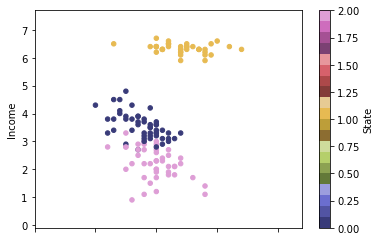

In [11]:
# initial data plot with classes
if provided_class == True:
    margin = 1
    a_limit = [df[columns[0]].min() - margin, df[columns[0]].max() + margin]
    b_limit = [df[columns[1]].min() - margin, df[columns[1]].max() + margin]
    if len(columns) == 2:
        if df.dtypes[-1] != object:
            df.plot.scatter(x=columns[0], y=columns[1], c=df.columns[-1], colormap='tab20b', xlim=a_limit, ylim=b_limit)
        else:
            print("Plot not available - Replace the decision class with a number")
    else:
        print("Plot not available - Objects have more than 2 attributes")

In [12]:
# drop of class information
if provided_class == True:
    df = df.drop([decision_class], axis=1)

In [13]:
# adding a column with predicted class
df["centroid"] = -1

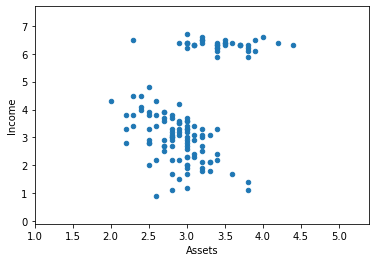

In [14]:
# initial data plot without classes
margin = 1
a_limit = [df[columns[0]].min() - margin, df[columns[0]].max() + margin]
b_limit = [df[columns[1]].min() - margin, df[columns[1]].max() + margin]
if len(columns) == 2:
    df.plot.scatter(x=columns[0], y=columns[1], xlim=a_limit, ylim=b_limit)
else:
    print("Plot not available - Objects have more than 2 attributes")

# -------------------- FUNCTIONS --------------------

### -------------------- DISTANCE METRICS --------------------

In [15]:
# Euclidean Metric
def __EuclideanMetric(array1, array2):
    sum_sq = np.sum(np.square(array1 - array2))
    return np.sqrt(sum_sq)

In [16]:
# Manhattan Metric (L1)
def __ManhattanMetric(array1, array2):
    return np.sum(np.abs(array1 - array2))

In [17]:
# Czebyshev Metric (L inf)
def __CzebyshevMetric(array1, array2):
    return np.max(np.abs(array1 - array2))

In [18]:
# Mahalanobis Metric
def __MahalanobisMetric(array1, array2, inv_cov_matrix):
    difference = np.array([array1 - array2])
    difference_T = difference.T
    left = np.dot(difference, inv_cov_matrix)
    mahal = np.dot(left, difference_T)
    return np.sqrt(mahal[0][0])

In [19]:
# calculate the distance between targets
def CalculateDistance(metric, p1, p2):
    if metric == "Euclidean":
        return __EuclideanMetric(p1[:-1], p2[:-1])
    elif metric == 'Manhattan':
        return __ManhattanMetric(p1[:-1], p2[:-1])
    elif metric == 'Czebyshev':
        return __CzebyshevMetric(p1[:-1], p2[:-1])
    elif metric == 'Mahalanobis':
        dfWithoutLastCol = df.iloc[:, :-1]
        cov_matrix = np.cov(dfWithoutLastCol.values.T)
        inv_cov_matrix = np.linalg.inv(cov_matrix)
        return __MahalanobisMetric(p1[:-1], p2[:-1], inv_cov_matrix)
    return -1

### -------------------- CENTROIDS --------------------

In [20]:
# determination of the initial position of the centroid (position of a random object)
def CreateCentroid(df):
    centroid_position = df.sample(n=1).iloc[0]
    return centroid_position

In [21]:
# creating k initial centroids
def CreateCentroidList(df, k):
    centroid_list = pd.DataFrame(columns=df.columns)
    for centroid in range(k):
        centroid_position = CreateCentroid(df)
        centroid_position["centroid"] = centroid
        centroid_list = centroid_list.append(centroid_position, ignore_index=True)
    return centroid_list

In [22]:
# assign each object to one of the centroids
def MatchObjectsWithCentroids(df, centroid_list):
    changes = 0
    # for each object
    for index_object, row_object in df.iterrows():
        # minimum distance
        min_dist = np.inf
        closest_centroid = 0
        # for each centroid
        for index_centroid, row_centroid in centroid_list.iterrows():
            # calculate the distance
            current_dist = CalculateDistance(distance_metric, row_object, row_centroid)
            # find the shortest distance
            if current_dist < min_dist:
                min_dist = current_dist
                closest_centroid = row_centroid["centroid"]
        # assign the object to this centroid
        if df.at[index_object, "centroid"] != closest_centroid:
            df.at[index_object, "centroid"] = closest_centroid
            changes = changes + 1
    return df, changes

In [23]:
# checking if any of the centroids doesn't have 0 objects assigned
def CheckIfAllClassesHaveObject(df, k):
    allHaveObject = True
    for current_k in range(0, k):
        currentHaveObject = current_k in df["centroid"].unique()
        if currentHaveObject == False:
            allHaveObject = False
            break
    return allHaveObject

In [24]:
# update of the centroid position
def UpdateCentroidPosition(df, centroid_list):
    # for each centroid
    for index_centroid, row_centroid in centroid_list.iterrows():
        # for each column
        for column in df.columns[:-1]:
            # calculate the average and substitute the centroid value
            row_centroid[column] = df.loc[df["centroid"] == row_centroid["centroid"]][column].mean()
    return centroid_list

### -------------------- SILHOUETTE --------------------

In [25]:
# calculation of the grouping quality measure - Silhouette
def GenerateSilhouette(df):
    # adding columns for quality determination
    df['a(i)'] = -1.0
    df['b(i)'] = -1.0
    df['s(i)'] = -1.0
    
    # number of objects in clusters
    cluster_counts = df.groupby('centroid')['centroid'].agg(['count'])

    # calculation of a(i)
    for index_object, row_object in df.iterrows():
        current_dist = 0.0
        for index_object_2, row_object_2 in df.iterrows():
            if row_object['centroid'] == row_object_2['centroid']:
                if distance_metric == "Mahalanobis":
                    current_dist += (1 / (cluster_counts.at[df.at[index_object, 'centroid'], 'count'] - 1)) * CalculateDistance("Euclidean", row_object, row_object_2)
                else:
                    current_dist += (1 / (cluster_counts.at[df.at[index_object, 'centroid'], 'count'] - 1)) * CalculateDistance(distance_metric, row_object, row_object_2)
        df.at[index_object, 'a(i)'] = current_dist
    
    # calculation of b(i)
    for index_object, row_object in df.iterrows():
        min_distance = np.inf
        for c in range(0, cluster_counts.shape[0]):
            current_dist = 0.0
            for index_object_2, row_object_2 in df.iterrows():
                if row_object['centroid'] != c and c == row_object_2['centroid']:
                    if distance_metric == "Mahalanobis":
                        current_dist += (1 / (cluster_counts.at[c, 'count'])) * CalculateDistance("Euclidean", row_object, row_object_2)
                    else:
                        current_dist += (1 / (cluster_counts.at[c, 'count'])) * CalculateDistance(distance_metric, row_object, row_object_2)
            if row_object['centroid'] != c:
                min_distance = np.minimum(min_distance, current_dist)
        df.at[index_object, 'b(i)'] = min_distance
    
    # calculation of s(i)
    for index_object, row_object in df.iterrows():
        if row_object['a(i)'] < row_object['b(i)']:
            df.at[index_object, 's(i)'] = 1 - row_object['a(i)'] / row_object['b(i)']
        elif row_object['a(i)'] == row_object['b(i)']:
            df.at[index_object, 's(i)'] = 0.0
        elif row_object['a(i)'] > row_object['b(i)']:
            df.at[index_object, 's(i)'] = row_object['b(i)'] / row_object['a(i)'] - 1
    
    return df

# -------------------- K-MEANS --------------------

In [26]:
CreateCentroidList(df, k)

,Assets,Income,centroid
0,4.0,6.6,0.0
1,2.9,6.4,1.0
2,2.6,3.4,2.0


In [27]:
# randomize the values until each centroid will have an object assigned to it
centroid_list = CreateCentroidList(df, k)
df, changes = MatchObjectsWithCentroids(df, centroid_list)

while CheckIfAllClassesHaveObject(df, k) == False:
    print("Trying...")
    centroid_list = CreateCentroidList(df, k)
    df, changes = MatchObjectsWithCentroids(df, centroid_list)

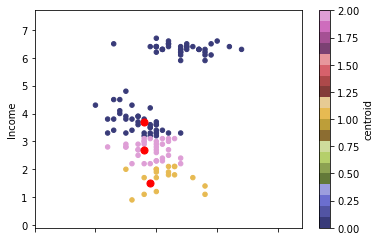

In [28]:
# plot with objects assigned to centroids
if len(columns) == 2:
    object_plot = df.plot.scatter(x=columns[0], y=columns[1], c="centroid", colormap='tab20b', xlim=a_limit, ylim=b_limit)
    centroid_list.plot.scatter(x=columns[0], y=columns[1], xlim=a_limit, ylim=b_limit, s=50, c='r', ax=object_plot)
else:
    print("Plot not available - Objects have more than 2 attributes")

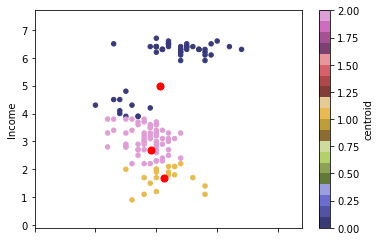

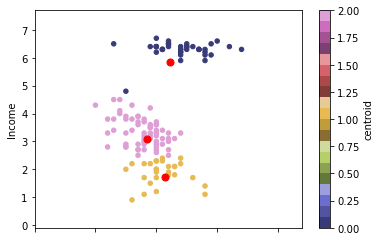

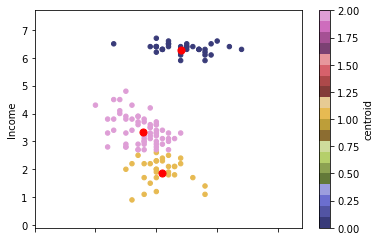

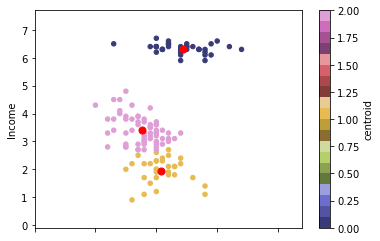

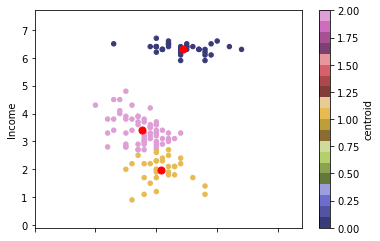

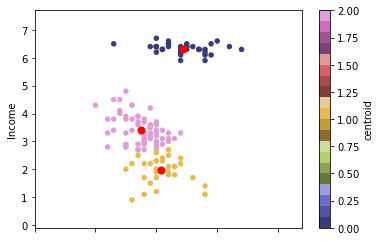

In [29]:
# updating centroid positions until no object changes
changes = -1
i = 0
while changes != 0 and i < iteration_limit:
    centroid_list = UpdateCentroidPosition(df, centroid_list)
    df, changes = MatchObjectsWithCentroids(df, centroid_list)
    if len(columns) == 2:
        object_plot = df.plot.scatter(x=columns[0], y=columns[1], c="centroid", colormap='tab20b', xlim=a_limit, ylim=b_limit)
        centroid_list.plot.scatter(x=columns[0], y=columns[1], xlim=a_limit, ylim=b_limit, s=50, c='r', ax=object_plot)
    i = i + 1

In [30]:
# file with all centroids
df.to_csv('out.csv',index=False)
df

,Assets,Income,centroid
0,2.8,3.2,2
1,3.4,6.4,0
2,2.2,3.3,2
3,3.2,3.0,2
4,3.0,3.2,2
...,...,...,...
127,2.8,2.7,2
128,3.0,2.8,2
129,3.3,1.8,1
130,3.7,6.3,0


In [31]:
# dataframe with silhouettes
df_silhouette = GenerateSilhouette(df)
df_silhouette

,Assets,Income,centroid,a(i),b(i),s(i)
0,2.8,3.2,2,0.531229,1.982260,0.732009
1,3.4,6.4,0,0.383575,3.905626,0.901789
2,2.2,3.3,2,0.800005,2.113767,0.621526
3,3.2,3.0,2,0.764355,1.745333,0.562058
4,3.0,3.2,2,0.625393,1.920440,0.674349
...,...,...,...,...,...,...
127,2.8,2.7,2,2.564365,4.325592,0.407165
128,3.0,2.8,2,2.604558,4.344837,0.400539
129,3.3,1.8,1,2.551261,4.842220,0.473122
130,3.7,6.3,0,2.340074,5.697539,0.589283


In [32]:
# silhouette for all centroids
df_silhouette.groupby('centroid').mean()

,Assets,Income,a(i),b(i),s(i)
centroid,,,,,
0,3.431579,6.331579,1.308453,4.683552,0.729628
1,3.081818,1.984848,1.504845,3.049103,0.519160
2,2.754098,3.422951,1.518209,3.265311,0.548796


In [33]:
# mean silhouette
df_silhouette['s(i)'].mean()

0.5934447405499073